In [39]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import List
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import multilabel_confusion_matrix
import lightgbm as lgb
import optuna

c:\MachineLearning\toxicComment\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
data = pd.read_csv('../data/trainToxic.csv')

In [3]:

STOPWORDS = set(stopwords.words('english') )
lemmatizer = WordNetLemmatizer()
PUNCT_DIGIT_REGEX = re.compile(f"[{re.escape(string.punctuation)}0-9\r\t\n]")

In [4]:
from typing import List

def Tokenization(text) -> List[str]:
    text = text.lower()
    text = PUNCT_DIGIT_REGEX.sub(" ", text)
    words = [w.encode('ascii','ignore').decode('ascii') for w in text.split()]
    words = [lemmatizer.lemmatize(word) for word in words if word not in STOPWORDS]
    # words = [words for words in text.split() if words not in STOPWORDS]

    words = [word for word in words if len(word) > 2]

    return words

In [53]:
TEXT_COL = "comment_text"
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

X_train,X_test,y_train,y_test = train_test_split(data[TEXT_COL], data[LABELS], test_size=0.3, random_state=42 )


In [54]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [55]:
tfidf = TfidfVectorizer(
    tokenizer=Tokenization,  
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    max_features=100000
)

X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Modelling and Trying the data


In [57]:
scoring = {
    "f1_micro": make_scorer(f1_score, average="micro"),
    "f1_macro": make_scorer(f1_score, average="macro"),
    "precision_micro": make_scorer(precision_score, average="micro"),
    "recall_micro": make_scorer(recall_score, average="micro"),
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": OneVsRestClassifier(
        LogisticRegression(
            C=1.0,
            penalty="l2",
            solver="saga",
            max_iter=2000,
            random_state=42
        )
    ),
    "Naive Bayes": OneVsRestClassifier(
        MultinomialNB(alpha=0.1)
    ),
    "LinearSVC": OneVsRestClassifier(
        LinearSVC(C=1.0, random_state=42,class_weight='balanced', max_iter=2000)
    ),
     "SGD Classifier": OneVsRestClassifier(
    SGDClassifier(
        loss="log_loss",      
        penalty="l2",
        alpha=1e-5,
        max_iter=1000,
        class_weight="balanced"
    )),
}

res = []

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    pipeline = Pipeline([
       
        ("clf", model)
    ])
    
    scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=kf,
        scoring=scoring,
        n_jobs=-1
    )
    
    res.append({
        "Model": model_name,
        "F1 Micro": scores["test_f1_micro"].mean(),
        "F1 Macro": scores["test_f1_macro"].mean(),
        "Precision Micro": scores["test_precision_micro"].mean(),
        "Recall Micro": scores["test_recall_micro"].mean(),
    })

results_df = pd.DataFrame(res).sort_values(by="F1 Micro", ascending=False)

print(results_df)


Training Logistic Regression...

Training Naive Bayes...

Training LinearSVC...

Training SGD Classifier...
                 Model  F1 Micro  F1 Macro  Precision Micro  Recall Micro
2            LinearSVC  0.693668  0.566950         0.653581      0.739097
3       SGD Classifier  0.677089  0.562773         0.572347      0.828962
0  Logistic Regression  0.631012  0.423977         0.895271      0.487322
1          Naive Bayes  0.623229  0.404157         0.817375      0.503629


F1s are good of just Linear SVC here but not great

Not Some great Numbers but average now 



Fitting Logistic Regression...

Fitting Naive Bayes...

Fitting LinearSVC...


c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\MachineLe


Fitting SGD Classifier...

Evaluating Logistic Regression...
Classification Report for Logistic Regression:

               precision    recall  f1-score   support

        toxic       0.93      0.57      0.71      4582
 severe_toxic       0.56      0.21      0.30       486
      obscene       0.93      0.58      0.72      2556
       threat       0.84      0.12      0.21       136
       insult       0.82      0.48      0.61      2389
identity_hate       0.74      0.14      0.24       432

    micro avg       0.89      0.51      0.65     10581
    macro avg       0.80      0.35      0.46     10581
 weighted avg       0.88      0.51      0.64     10581
  samples avg       0.05      0.04      0.05     10581

Confusion Matrix for Logistic Regression:



c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


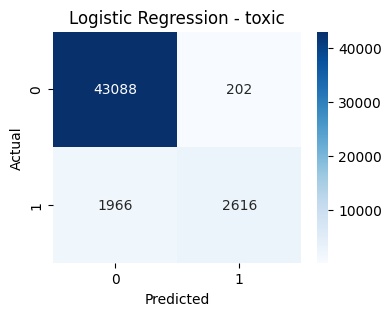

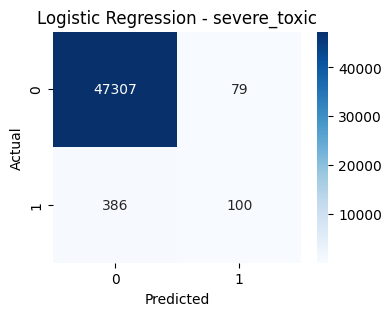

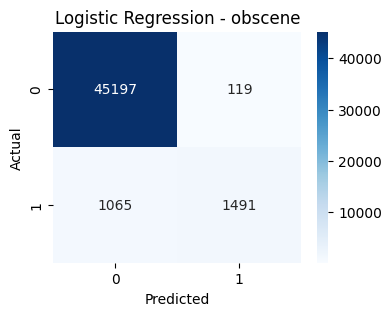

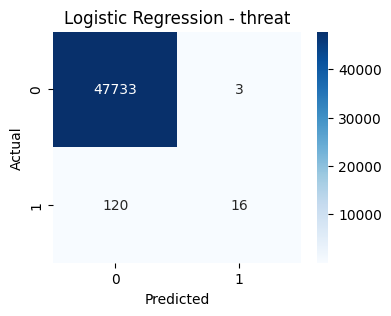

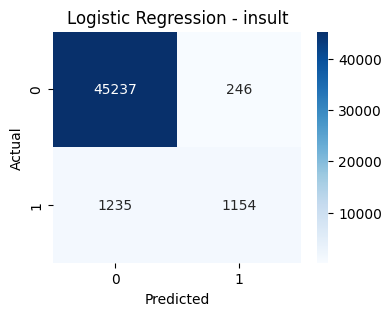

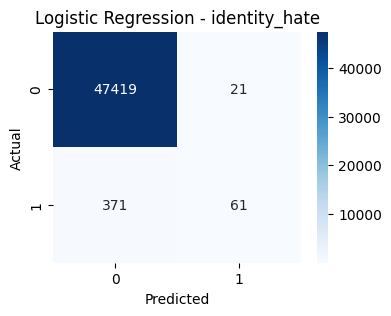


Evaluating Naive Bayes...
Classification Report for Naive Bayes:

               precision    recall  f1-score   support

        toxic       0.86      0.56      0.68      4582
 severe_toxic       0.57      0.22      0.32       486
      obscene       0.86      0.55      0.67      2556
       threat       0.50      0.01      0.03       136
       insult       0.77      0.48      0.59      2389
identity_hate       0.60      0.08      0.14       432

    micro avg       0.83      0.50      0.62     10581
    macro avg       0.69      0.32      0.41     10581
 weighted avg       0.81      0.50      0.61     10581
  samples avg       0.05      0.04      0.04     10581

Confusion Matrix for Naive Bayes:



c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


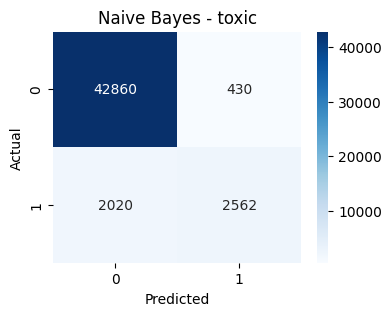

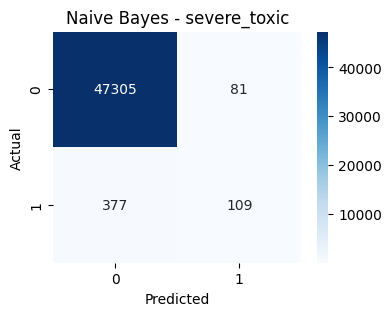

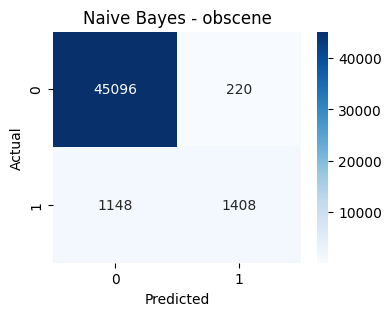

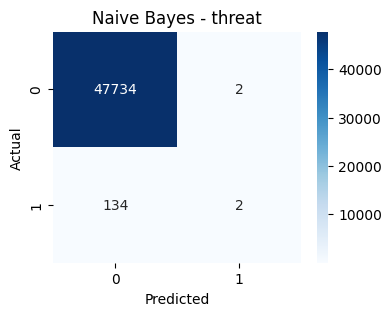

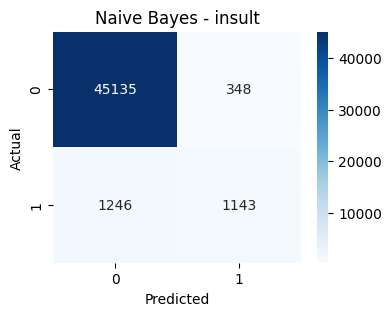

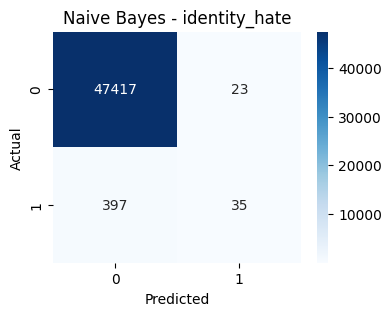


Evaluating LinearSVC...
Classification Report for LinearSVC:

               precision    recall  f1-score   support

        toxic       0.70      0.78      0.74      4582
 severe_toxic       0.31      0.59      0.41       486
      obscene       0.74      0.80      0.77      2556
       threat       0.46      0.46      0.46       136
       insult       0.63      0.75      0.68      2389
identity_hate       0.36      0.51      0.42       432

    micro avg       0.64      0.76      0.70     10581
    macro avg       0.53      0.65      0.58     10581
 weighted avg       0.66      0.76      0.70     10581
  samples avg       0.06      0.07      0.06     10581

Confusion Matrix for LinearSVC:



c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


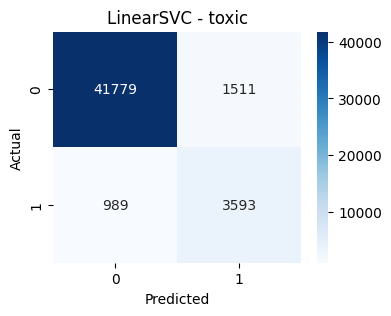

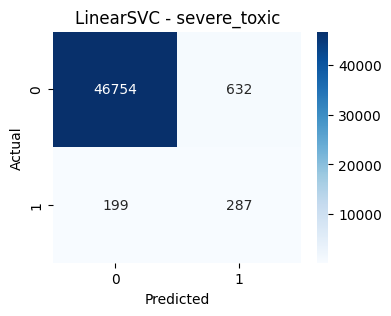

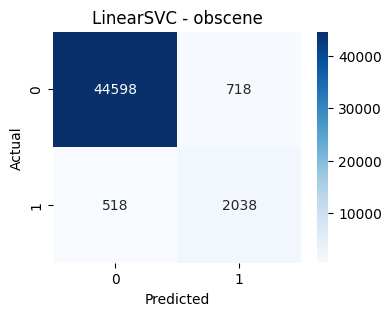

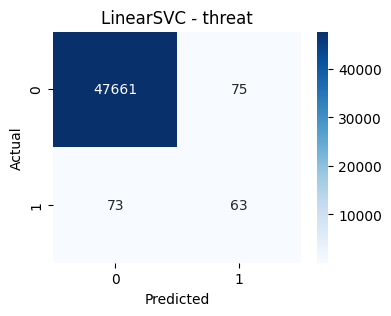

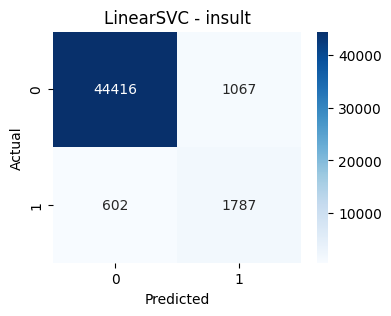

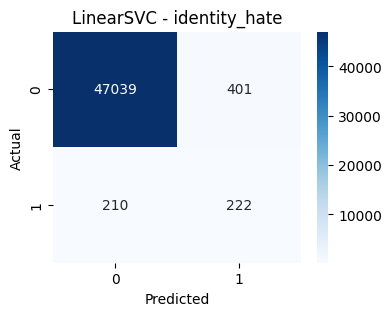


Evaluating SGD Classifier...
Classification Report for SGD Classifier:

               precision    recall  f1-score   support

        toxic       0.64      0.84      0.73      4582
 severe_toxic       0.28      0.82      0.41       486
      obscene       0.68      0.87      0.76      2556
       threat       0.28      0.67      0.39       136
       insult       0.56      0.86      0.68      2389
identity_hate       0.26      0.77      0.38       432

    micro avg       0.56      0.84      0.67     10581
    macro avg       0.45      0.80      0.56     10581
 weighted avg       0.59      0.84      0.69     10581
  samples avg       0.06      0.08      0.07     10581

Confusion Matrix for SGD Classifier:



c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


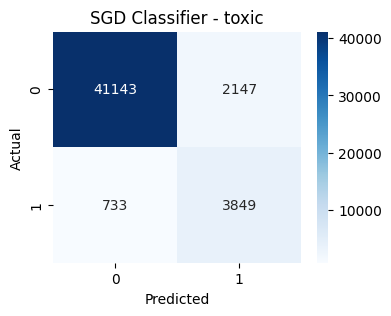

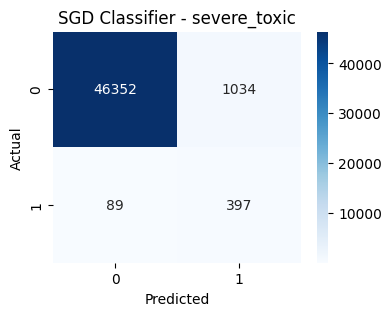

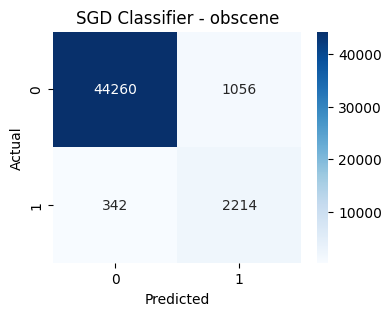

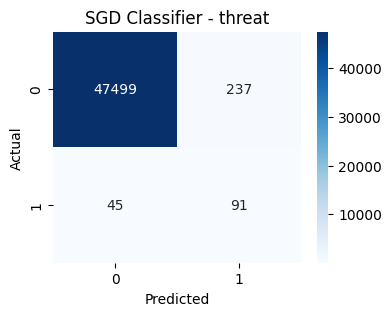

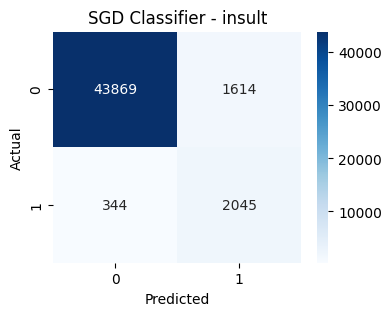

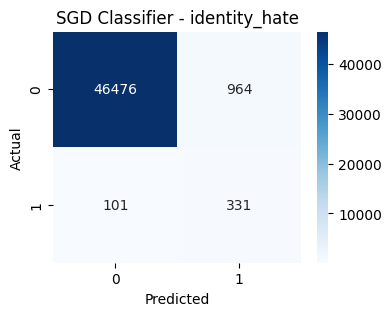

In [58]:
#fitting the models for the confusion matrix and classification report
fitted_models = {}
for model_name, model in models.items():
    print(f"\nFitting {model_name}...")
    
    pipeline = Pipeline([
       
        ("clf", model)
    ])
    
    pipeline.fit(X_train, y_train)
    fitted_models[model_name] = pipeline
for model_name, pipeline in fitted_models.items():
    print(f"\nEvaluating {model_name}...")
    y_pred = pipeline.predict(X_test)
    
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, target_names=LABELS))
    
    print(f"Confusion Matrix for {model_name}:\n")
    cm = multilabel_confusion_matrix(y_test, y_pred)
    for i, label in enumerate(y_test.columns):
        plt.figure(figsize=(4,3))
        sns.heatmap(cm[i], annot=True, fmt="d", cmap="Blues")
        plt.title(f"{model_name} - {label}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

In [ ]:
lgb_model = OneVsRestClassifier(
    lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        class_weight="balanced",
        random_state=42
    )
)
pipeline = Pipeline([("clf", lgb_model)])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(f"Classification Report for LightGBM:\n")
print(classification_report(y_test,y_pred, target_names = LABELS))
 

[LightGBM] [Info] Number of positive: 10712, number of negative: 100987
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 14.194665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 840984
[LightGBM] [Info] Number of data points in the train set: 111699, number of used features: 24461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1109, number of negative: 110590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 13.108052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 840984
[LightGBM] [Info] Number of data points in the train set: 111699, number of used features: 24461
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[

c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Not some good results with lgb also 

In [ ]:
#trial for Logistic Regression
def objective_logistic(trial):
    C = trial.suggest_loguniform('C', 1e-4, 10.0)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = 'saga' if penalty == 'l1' else 'lbfgs'
    max_iter = trial.suggest_int('max_iter', 1000, 5000)
    
    model = OneVsRestClassifier(
        LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            max_iter=max_iter,
            random_state=42
        )
    )
    
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=make_scorer(f1_score, average="macro"), n_jobs=-1)
    return scores.mean()
study_logistic = optuna.create_study(direction='maximize')
study_logistic.optimize(objective_logistic, n_trials=25)



[I 2026-02-23 13:38:25,303] A new study created in memory with name: no-name-f092c217-d011-4838-8599-e616e7bed442
C:\Users\dell\AppData\Local\Temp\ipykernel_8736\2906439720.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 10.0)
[I 2026-02-23 13:39:25,144] Trial 0 finished with value: 0.25094810311654164 and parameters: {'C': 0.1582359624993029, 'penalty': 'l2', 'max_iter': 1951}. Best is trial 0 with value: 0.25094810311654164.
[I 2026-02-23 13:39:41,005] Trial 1 finished with value: 0.0 and parameters: {'C': 0.003098196482493813, 'penalty': 'l2', 'max_iter': 4868}. Best is trial 0 with value: 0.25094810311654164.
[I 2026-02-23 13:40:41,965] Trial 2 finished with value: 0.2597499478134701 and parameters: {'C': 0.037191879467849694, 'penalty': 'l1', 'max_iter': 1116}. Best is trial 2 wi

KeyboardInterrupt: 

In [61]:
print("Best hyperparameters for Logistic Regression: ", study_logistic.best_params)
print("Best Macro F1:", study_logistic.best_value)

Best hyperparameters for Logistic Regression:  {'C': 0.051980427470978294, 'penalty': 'l1', 'max_iter': 1141}
Best Macro F1: 0.29980117826198704


In [59]:
def objective_sgd(trial):
    #hyperparameters to tune for the SGDClassifier
    alpha = trial.suggest_loguniform('alpha', 1e-6, 1e-2)
    max_iter = trial.suggest_int('max_iter',500,2000)
    loss = trial.suggest_categorical('loss',['hinge','log_loss'])
    penalty = trial.suggest_categorical('penalty',['l2','l1'])
    learning_rate = trial.suggest_categorical('learning_rate',['constant','optimal','invscaling'])
    early_stopping = trial.suggest_categorical('early_stopping',[True,False])
    class_weight = trial.suggest_categorical('class_weight',['balanced',None])
    average = trial.suggest_int('average', 1, 10)

    # Create the model with the suggested hyperparameters
    model = OneVsRestClassifier(
        SGDClassifier(
            alpha = alpha,
            max_iter  = max_iter,
            loss = loss,
            penalty = penalty,
            learning_rate = learning_rate,
            early_stopping =early_stopping,
            class_weight = class_weight,
            random_state = 42,
            average = average,
            eta0  = 0.01

        )
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')

study = optuna.create_study(direction = 'maximize')
study.optimize(objective_sgd, n_trials = 50)
print("Best hyperparameters: ", study.best_params)

[I 2026-02-23 13:28:47,877] A new study created in memory with name: no-name-95f1d880-7a31-4fcc-8d1d-40a1b4d02c9f
C:\Users\dell\AppData\Local\Temp\ipykernel_8736\1503012427.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-6, 1e-2)
[I 2026-02-23 13:28:52,501] Trial 0 finished with value: 0.30937009070965477 and parameters: {'alpha': 4.982418555133694e-06, 'max_iter': 1341, 'loss': 'hinge', 'penalty': 'l2', 'learning_rate': 'constant', 'early_stopping': False, 'class_weight': None, 'average': 3}. Best is trial 0 with value: 0.30937009070965477.
C:\Users\dell\AppData\Local\Temp\ipykernel_8736\1503012427.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_fl

Best hyperparameters:  {'alpha': 1.4924555994603568e-06, 'max_iter': 1274, 'loss': 'hinge', 'penalty': 'l2', 'learning_rate': 'constant', 'early_stopping': True, 'class_weight': 'balanced', 'average': 6}


In [ ]:
def objective_SVC(trial):
    C = trial.suggest_loguniform('C', 1e-3, 10.0)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    tol = trial.suggest_loguniform('tol', 1e-5, 1e-3)
    max_iter = trial.suggest_int('max_iter', 1000, 5000)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    dual = trial.suggest_categorical('dual', [True, False])
    if dual == False and loss == 'hinge':
        return 0.0

    model = OneVsRestClassifier(
        LinearSVC(C=C, loss=loss, tol=tol, max_iter=max_iter, class_weight=class_weight, dual=dual, random_state=42)
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')
study_svc = optuna.create_study(direction = 'maximize')
study_svc.optimize(objective_SVC, n_trials = 50)


In [ ]:
print("Best hyperparameters for SVC: ", study_svc.best_params)

print("Best Macro F1:", study_svc.best_value)

Best hyperparameters for SVC:  {'C': 0.7573353596988827, 'loss': 'hinge', 'tol': 0.00011496506849045187, 'max_iter': 4283, 'class_weight': 'balanced', 'dual': True}
Best Macro F1: 0.5908456627740314


Got better results with  SVC then i will stick with it now


In [ ]:
#Training the model for dataset
best_params_svc = {
    'C': 0.7573353596988827,
    'loss': 'hinge',
    'tol': 0.00011496506849045187,
    'max_iter': 4283,
    'class_weight': 'balanced',
    'dual': True
}

model_svc = OneVsRestClassifier(
    LinearSVC(
        C=best_params_svc['C'],
        loss=best_params_svc['loss'],
        tol=best_params_svc['tol'],
        max_iter=best_params_svc['max_iter'],
        class_weight=best_params_svc['class_weight'],
        dual=best_params_svc['dual'],
        random_state=42
    )
)


model_svc.fit(X_train, y_train)
y_pred_svc = model_svc.predict(X_test)
print(f"Classification Report for SVC with Best Hyperparameters:\n")
print(classification_report(y_test, y_pred_svc, target_names=LABELS))


c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report for SVC with Best Hyperparameters:

               precision    recall  f1-score   support

        toxic       0.66      0.82      0.73      4582
 severe_toxic       0.32      0.68      0.44       486
      obscene       0.72      0.84      0.77      2556
       threat       0.42      0.51      0.46       136
       insult       0.61      0.80      0.69      2389
identity_hate       0.38      0.57      0.45       432

    micro avg       0.62      0.80      0.70     10581
    macro avg       0.52      0.70      0.59     10581
 weighted avg       0.63      0.80      0.70     10581
  samples avg       0.06      0.08      0.07     10581



c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\MachineLearning\toxicComment\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Useful code 


Train Classification Metrics:

     Class  Precision    Recall        F1
0  Class_0   0.770541  0.992812  0.867667
1  Class_1   0.460641  0.997295  0.630199
2  Class_2   0.784768  0.994909  0.877432
3  Class_3   0.648956  1.000000  0.787112
4  Class_4   0.693989  0.995080  0.817699
5  Class_5   0.562718  0.995889  0.719109


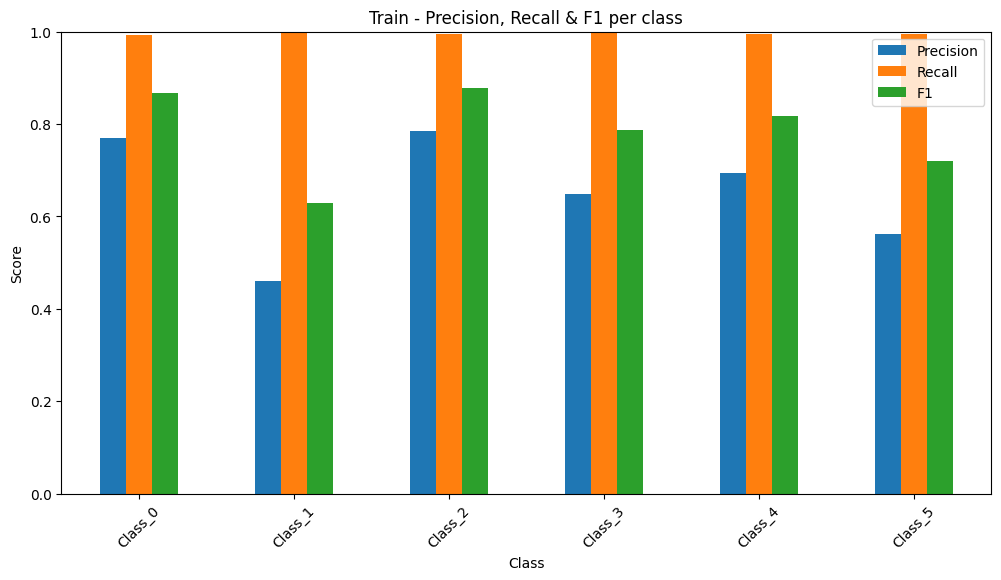


Test Classification Metrics:

     Class  Precision    Recall        F1
0  Class_0   0.661032  0.819293  0.731703
1  Class_1   0.323558  0.681070  0.438701
2  Class_2   0.715768  0.836463  0.771423
3  Class_3   0.418182  0.507353  0.458472
4  Class_4   0.605687  0.802428  0.690313
5  Class_5   0.377099  0.571759  0.454462


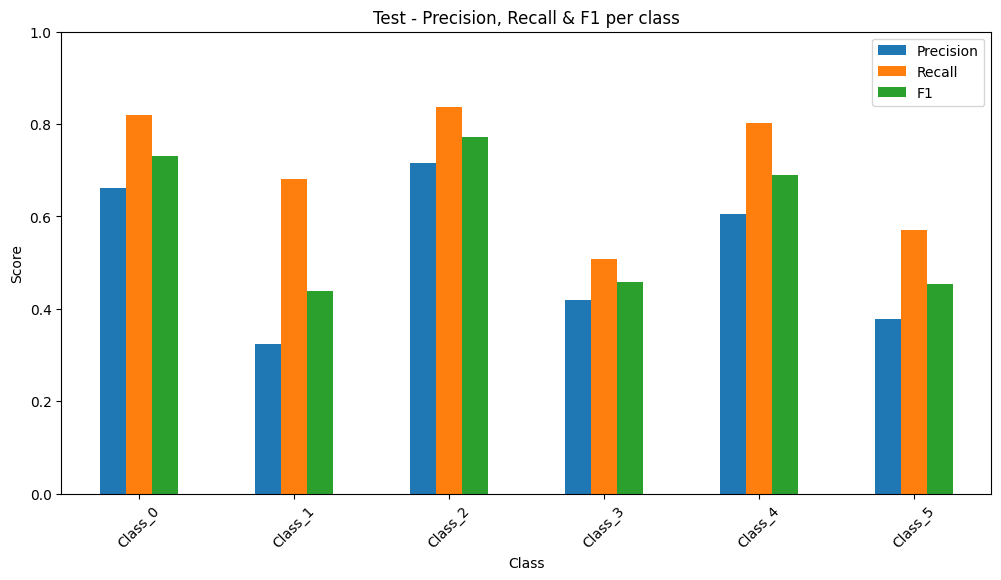

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

def evaluate_model(y_true, y_pred, set_name="Test"):
    # Convert to NumPy arrays if they are DataFrames
    if hasattr(y_true, "to_numpy"):
        y_true = y_true.to_numpy()
    if hasattr(y_pred, "toarray"):  # if predictions are sparse
        y_pred = y_pred.toarray()    

    metrics = {
        "Class": [],
        "Precision": [],
        "Recall": [],
        "F1": []
    }
    
    num_classes = y_true.shape[1]
    
    for i in range(num_classes):
        metrics["Class"].append(f"Class_{i}")
        metrics["Precision"].append(
            precision_score(y_true[:, i], y_pred[:, i], zero_division=0)
        )
        metrics["Recall"].append(
            recall_score(y_true[:, i], y_pred[:, i], zero_division=0)
        )
        metrics["F1"].append(
            f1_score(y_true[:, i], y_pred[:, i], zero_division=0)
        )
    
    df = pd.DataFrame(metrics)
    print(f"\n{set_name} Classification Metrics:\n")
    print(df)
    
    
    df.plot(x="Class", y=["Precision", "Recall", "F1"], kind="bar", figsize=(12,6))
    plt.title(f"{set_name} - Precision, Recall & F1 per class")
    plt.ylabel("Score")
    plt.ylim(0,1)
    plt.xticks(rotation=45)
    plt.show()






y_train_pred = model_svc.predict(X_train)
y_test_pred = model_svc.predict(X_test)

# Evaluate train set
evaluate_model(y_train, y_train_pred, set_name="Train")

# Evaluate test set
evaluate_model(y_test, y_test_pred, set_name="Test")

Fails for the 1st and third and 5th class needed to improve here